In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Optional, Dict
import pickle

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from geographiclib.geodesic import Geodesic

from lib.state import PersonState
from lib.results import SimulationResult, SimulationResultStorage
%matplotlib inline

In [3]:
fraction_of_populace_returning_per_day = 0.001 
fraction_returning_travelers_infected = .01

max_distance_from_airport_km = 20

incubation_period_days = 5
days_sick = 14

avg_num_others_infected = 2.5
avg_num_others_infected_with_social_distancing = 1.5

prob_survive = 0.975

airport_location_lon = 4.764167
airport_location_lat = 52.308056

In [4]:
dfp = (
    gpd
    .read_file("./data/transformed/population.shp")
    .assign(centroid=lambda df: df["geometry"].map(lambda x: x.centroid))
    .drop("geometry", axis=1)
    .assign(
        airport_distance_km=
        lambda df: df["centroid"].map(
            lambda c: Geodesic.WGS84.Inverse(
                airport_location_lat, airport_location_lon, 
                c.y, c.x)["s12"] / 1000
        )
    )
)
len_dfp_all = len(dfp)
total_population = dfp["pop"].sum()

dfp = dfp[dfp["airport_distance_km"] < max_distance_from_airport_km]
dfp.index.name = "hood_id"
selected_population = dfp["pop"].sum()
print(f"{len_dfp_all} neighbourhoods in total "
      f"({total_population=}),\n"
      f"{len(dfp)} left after restricting on proximity "
      f"to airport ({selected_population=}).")
pd.concat((dfp.head(), dfp.tail()))

2794 neighbourhoods in total (total_population=16891285),
139 left after restricting on proximity to airport (selected_population=1806125).


,hood,muni,pop,centroid,airport_distance_km
hood_id,,,,,
85,Wijk 00 Aalsmeer,Aalsmeer,12030,POINT (4.73681 52.25318),6.384820
86,Wijk 01 Kudelstraat en Kalslagen,Aalsmeer,9200,POINT (4.73985 52.23702),8.076712
87,Wijk 02 Oosteinde,Aalsmeer,9840,POINT (4.79539 52.28221),3.579371
135,Wijk 01 Oudshoorn,Alphen aan den Rijn,9420,POINT (4.64053 52.15127),19.383784
136,Wijk 02 Ridderveld,Alphen aan den Rijn,13545,POINT (4.67613 52.15364),18.204701
2697,Wijk 81 Westzaan,Zaanstad,4505,POINT (4.77330 52.45122),15.942672
2702,Bentveld,Zandvoort,950,POINT (4.57213 52.36366),14.478534
2703,Buitengebied,Zandvoort,20,POINT (4.54321 52.35469),15.931547
2704,Zandvoort Noord,Zandvoort,7570,POINT (4.54313 52.38240),17.185225


In [5]:
dfp.groupby("muni")["pop"].sum().sort_values(ascending=False).head(10)

muni
Amsterdam              821705
Haarlem                156625
Haarlemmermeer         144060
Zaanstad               122530
Amstelveen              87160
Velsen                  58070
De Ronde Venen          42575
Alphen aan den Rijn     34175
Aalsmeer                31070
Uithoorn                28715
Name: pop, dtype: int64

In [6]:
def build_population_df_func(dfp: pd.DataFrame) -> pd.DataFrame:
    """Builds a DataFrame for the population where everyone is  
    still 'untouched' by the virus.
    """
    pop_hood_ids = []
    for hood_id, row in dfp.iterrows():
        pop_hood_ids.extend([hood_id] * row["pop"])
    assert len(pop_hood_ids) == selected_population
    
    def create_df():
        return pd.DataFrame({
            "person_id": range(selected_population),
            "infection_day": pd.NA,
            "state": PersonState.untouched,
            "hood_id": pop_hood_ids
        }).set_index("person_id") 
    return create_df

In [7]:
build_population_df = build_population_df_func(dfp)

In [8]:
pop = build_population_df()
pd.concat((pop.head(2), pop.tail(2)))

,infection_day,state,hood_id
person_id,,,
0,<NA>,PersonState.untouched,85
1,<NA>,PersonState.untouched,85
1806123,<NA>,PersonState.untouched,2705
1806124,<NA>,PersonState.untouched,2705


In [9]:
def simulate_spread(day: int, 
                    pop: pd.DataFrame,
                    prob_infect_daily: float, 
                    prob_infect_daily_with_social_distancing: float,
                    social_distancing_day: Optional[int] = None
                   ) -> pd.DataFrame:
    """Simulate the spreading of the virus within the population."""
    if isinstance(social_distancing_day, int) \
            and day >= social_distancing_day:
        # Social Distancing is in place!
        effective_prob_inf_daily = prob_infect_daily_with_social_distancing
    else:
        effective_prob_inf_daily = prob_infect_daily
    
    pop_contagious = (
        pop[(pop["state"] == PersonState.infected) &
            (pop["infection_day"] + incubation_period_days <= day)]
        .assign(infect_other=lambda df: 
                np.random.random(size=len(df)) < effective_prob_inf_daily)
        .query("infect_other == True")
    )
    pop_contagious_per_hood = pop_contagious.groupby("hood_id").sum()
    
    for hood_id, num_to_infect in pop_contagious_per_hood.itertuples():
        # Let's see who they spread the virus to. Only "untouched" will
        # actually be infected, the others already are or are immune.
        pop_to_spread_to = pop[
            (pop["hood_id"] == hood_id) &
            (pop["state"].isin({PersonState.untouched, 
                                PersonState.infected, 
                                PersonState.recovered}))
        ]
        # It might not be possible if the hood is completely saturated:
        n_to_spread_to = len(pop_to_spread_to)
        if n_to_spread_to == 0:
            continue
        
        # Or, spread to less people if the hood is partially saturated:
        num_to_infect = min(int(num_to_infect), n_to_spread_to)
        # Here, we allow spread of the virus to infected & recovered,
        # but we only let it have an effect on untouched:
        unlucky_persons = pop_to_spread_to.sample(num_to_infect, replace=False)
        unlucky_persons = unlucky_persons[
            unlucky_persons["state"] == PersonState.untouched
        ]
        unlucky_persons_idx = unlucky_persons.index
        
        if len(unlucky_persons_idx) > 0:
            pop.loc[unlucky_persons_idx, "state"] = PersonState.infected
            pop.loc[unlucky_persons_idx, "infection_day"] = day

    return pop

def simulate_cure_or_death(day: int, pop: pd.DataFrame) -> pd.DataFrame:
    """After `days_sick` days have elapsed, a person's state transitions to
    either deceased or recovered.
    """
    pop_to_decide = pop[(pop["state"] == PersonState.infected) &
                        (pop["infection_day"] < 
                         day - (days_sick + incubation_period_days))]
    n = len(pop_to_decide)
    pop_deceased_idx = pop_to_decide \
        .sample(int(n * (1 - prob_survive)), replace=False).index
    pop_recover_idx = set(pop_to_decide.index) - set(pop_deceased_idx)

    pop.loc[pop_recover_idx, "state"] = PersonState.recovered
    pop.loc[pop_deceased_idx, "state"] = PersonState.deceased
    
    return pop

def simulate_travel(day: int, pop: pd.DataFrame, 
                    n_travelers_return_infected: int, 
                    travel_restriction_day: Optional[int] = None
                   ) -> pd.DataFrame:
    """Simulate air travel arrivals; some of which will be infected.
    Turns into a no-op if travel restriction is in place 
    (day >= travel_restriction_day).
    """
    if isinstance(travel_restriction_day, int) \
            and day >= travel_restriction_day:
        # Travel restriction is in place!
        return pop

    return_idx = pop.sample(n=n_travelers_return_infected, 
                            replace=False).index
    
    pop.loc[return_idx, "state"] = PersonState.infected
    pop.loc[return_idx, "infection_day"] = day
    
    return pop

In [10]:
def simulate(pop: pd.DataFrame, 
             n_days, 
             travel_restriction_day: Optional[int] = None,
             social_distancing_day: Optional[int] = None
            ) -> SimulationResult:
    result = SimulationResult(len(pop), n_days, travel_restriction_day, social_distancing_day)

    n_travelers_return_infected = round(
        len(pop) * 
        fraction_of_populace_returning_per_day *
        fraction_returning_travelers_infected
    )
    prob_infect_daily = avg_num_others_infected / days_sick
    prob_infect_daily_with_social_distancing = \
        avg_num_others_infected_with_social_distancing / days_sick

    for day in tqdm(range(n_days)):
        pop = simulate_travel(day, pop, n_travelers_return_infected, 
                              travel_restriction_day)
        pop = simulate_spread(day, pop, 
                              prob_infect_daily, 
                              prob_infect_daily_with_social_distancing,
                              social_distancing_day
                             )
        pop = simulate_cure_or_death(day, pop)
        result.add_day_results(pop)
        
    result.finalize()
    return result

In [11]:
def run(storage: SimulationResultStorage, n_days=250, 
        travel_restriction_day=None, social_distancing_day=None):
    pop = build_population_df()
    
    result = simulate(pop, 
                      n_days=n_days,
                      travel_restriction_day=travel_restriction_day,
                      social_distancing_day=social_distancing_day)
    
    result.print_summary()
    for log in [False, True]:
        result.plot_count_curves(log=log)
        
    storage.add(result)

In [12]:
storage = SimulationResultStorage()


Population:      1,806,125
Deceased:           42,036 ( 2.3 %)
Peak infected:     721,722 (40.0 %)
Total affected:  1,686,572 (93.4 %)


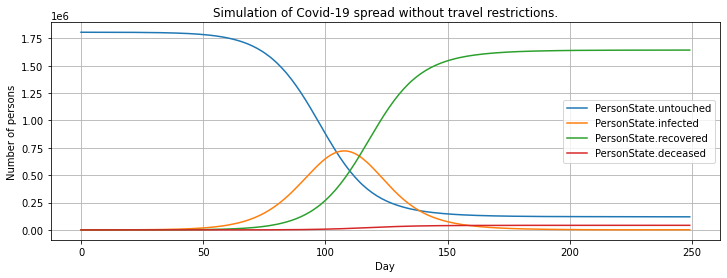

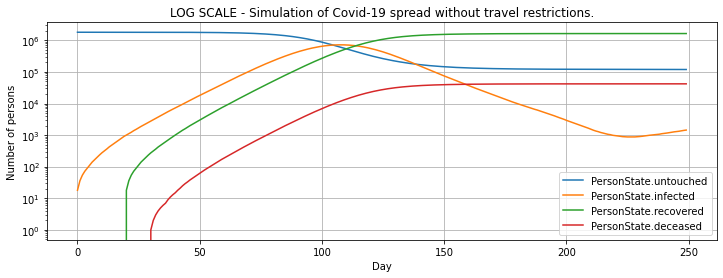

In [13]:
run(storage)


Population:      1,806,125
Deceased:                0 ( 0.0 %)
Peak infected:           0 ( 0.0 %)
Total affected:          0 ( 0.0 %)


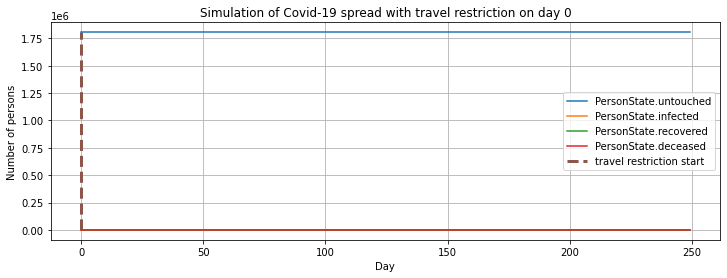

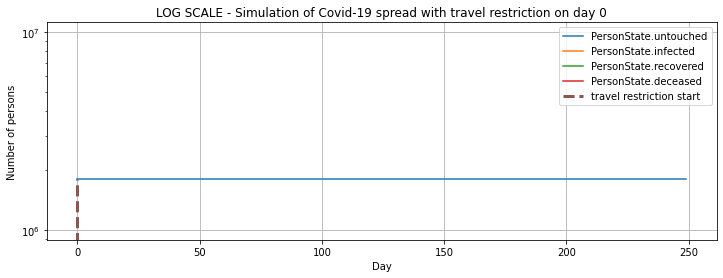

In [14]:
run(storage, travel_restriction_day=0)


Population:      1,806,125
Deceased:           27,132 ( 1.5 %)
Peak infected:     476,846 (26.4 %)
Total affected:  1,088,792 (60.3 %)


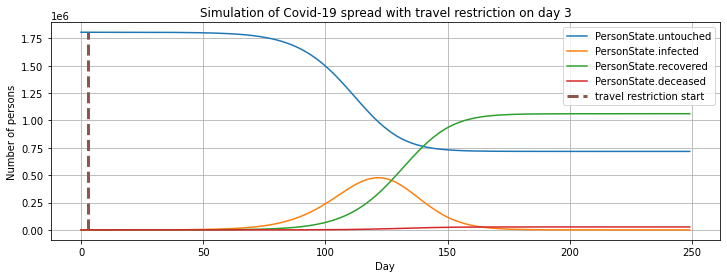

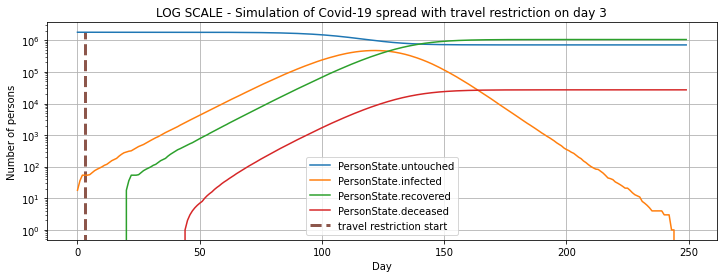

In [15]:
run(storage, travel_restriction_day=3)


Population:      1,806,125
Deceased:           34,419 ( 1.9 %)
Peak infected:     604,156 (33.5 %)
Total affected:  1,380,449 (76.4 %)


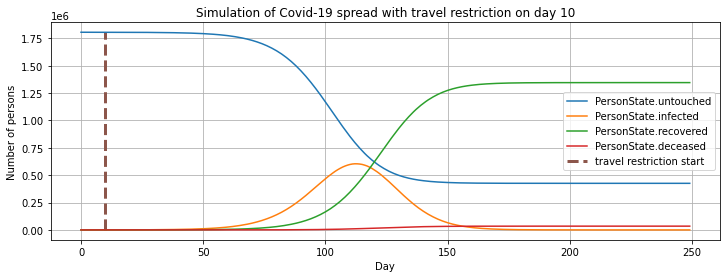

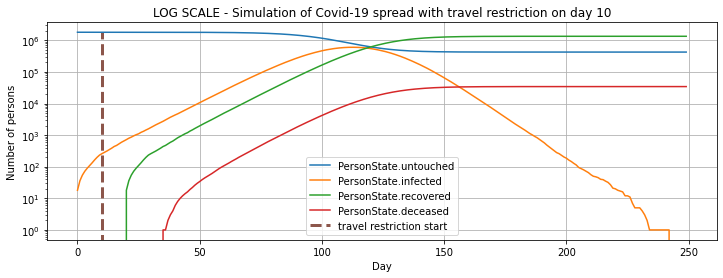

In [16]:
run(storage, travel_restriction_day=10)


Population:      1,806,125
Deceased:           41,149 ( 2.3 %)
Peak infected:     729,779 (40.4 %)
Total affected:  1,649,624 (91.3 %)


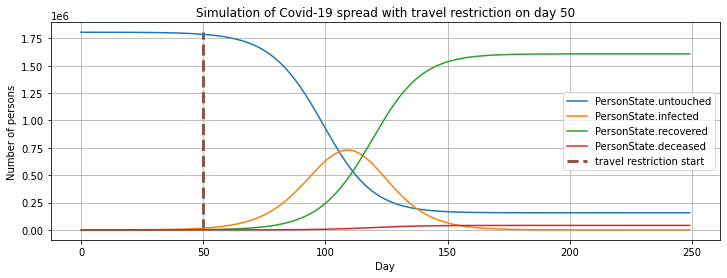

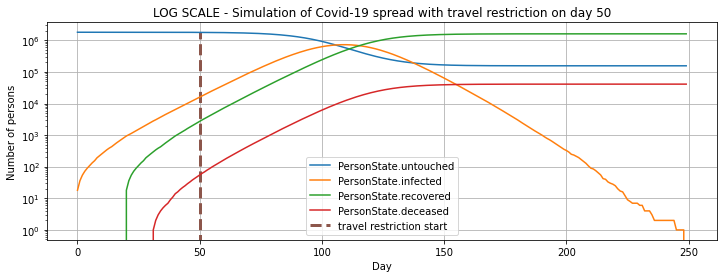

In [17]:
run(storage, travel_restriction_day=50)


Population:      1,806,125
Deceased:           31,008 ( 1.7 %)
Peak infected:     272,733 (15.1 %)
Total affected:  1,264,026 (70.0 %)


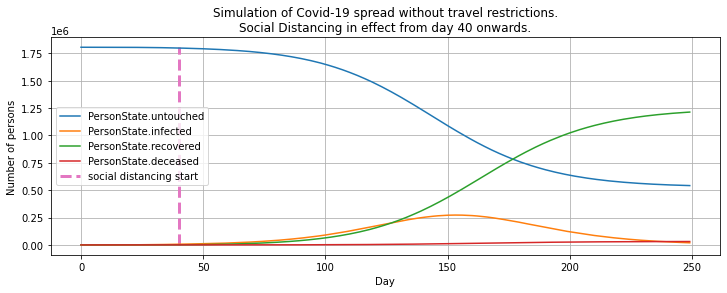

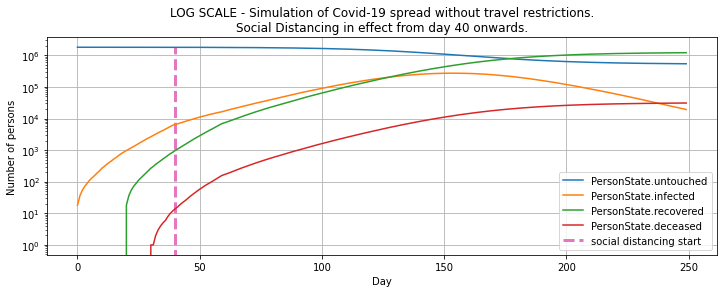

In [18]:
run(storage, social_distancing_day=40)


Population:      1,806,125
Deceased:           31,418 ( 1.7 %)
Peak infected:     285,706 (15.8 %)
Total affected:  1,270,620 (70.4 %)


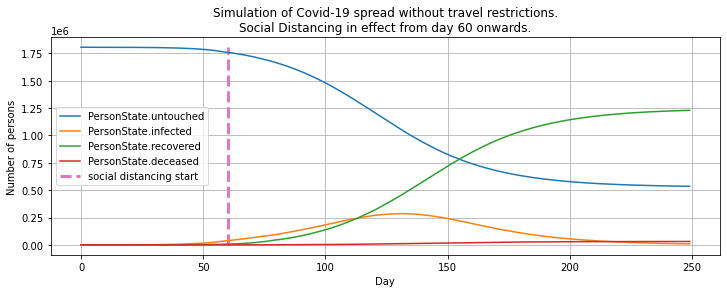

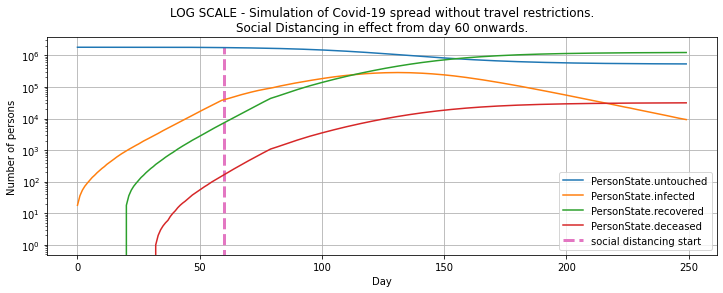

In [19]:
run(storage, social_distancing_day=60)


Population:      1,806,125
Deceased:           32,892 ( 1.8 %)
Peak infected:     367,975 (20.4 %)
Total affected:  1,327,494 (73.5 %)


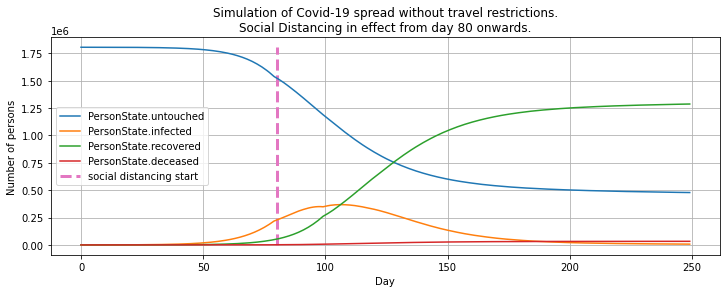

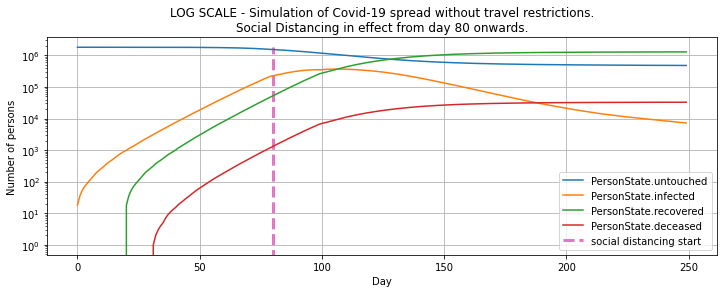

In [20]:
run(storage, social_distancing_day=80)


Population:      1,806,125
Deceased:           30,113 ( 1.7 %)
Peak infected:     266,553 (14.8 %)
Total affected:  1,226,293 (67.9 %)


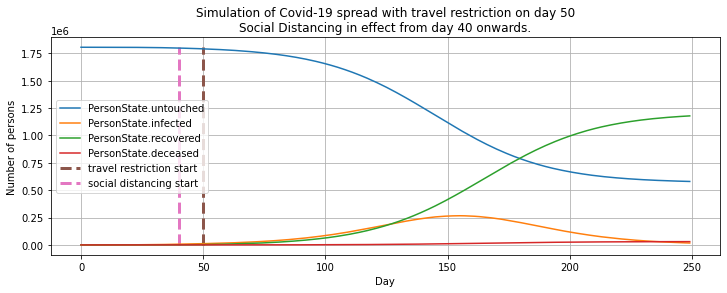

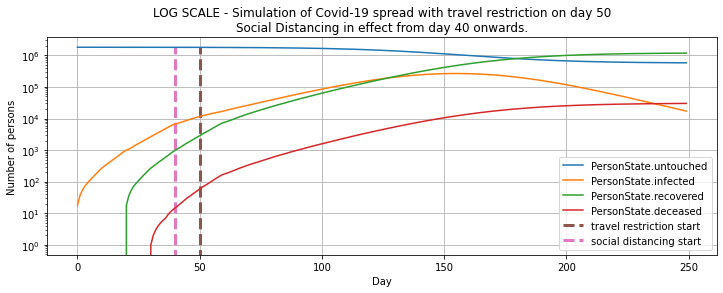

In [21]:
run(storage, social_distancing_day=40, travel_restriction_day=50)

In [22]:
(
    pd.DataFrame([
        {
            "tr_day": sr.travel_restriction_day,
            "sd_day": sr.social_distancing_day,
            "perc_deceased": sr.perc_deceased,
            "perc_peak_infected": sr.perc_peak_infected,
            "perc_total_affected": sr.perc_total_affected,
        } for key, sr in storage.results.items()]
    )
    .set_index(["tr_day", "sd_day"])
    .query("tr_day != 0")
    .round(2)
    .sort_values(by="perc_peak_infected", ascending=False)
)

perc_deceased  perc_peak_infected  perc_total_affected
tr_day sd_day                                                        
50.0   NaN              2.28               40.41                91.33
NaN    NaN              2.33               39.96                93.38
10.0   NaN              1.91               33.45                76.43
3.0    NaN              1.50               26.40                60.28
NaN    80.0             1.82               20.37                73.50
       60.0             1.74               15.82                70.35
       40.0             1.72               15.10                69.99
50.0   40.0             1.67               14.76                67.90

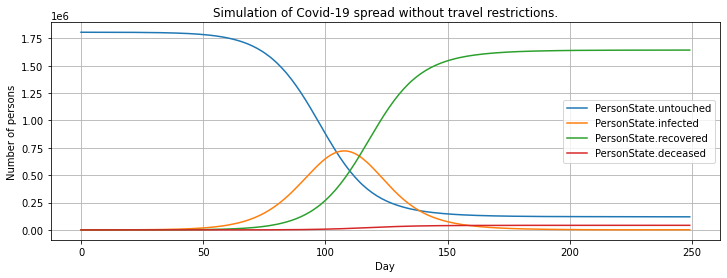

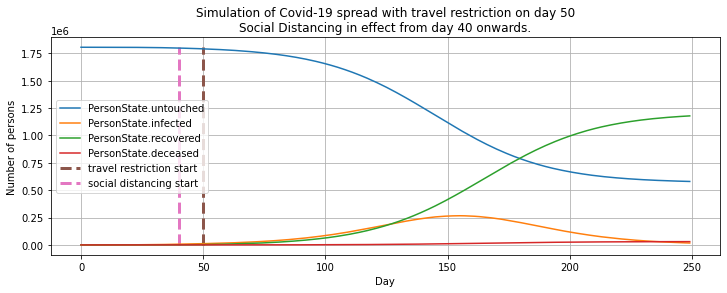

In [23]:
storage["SimulationResult(n_days=250, tr_day=None, sd_day=None)"].plot_count_curves()
storage["SimulationResult(n_days=250, tr_day=50, sd_day=40)"].plot_count_curves()